# Projet de prédiction des données liées au Covid

## Imports globaux

In [236]:
import matplotlib.pyplot as plt
import pandas as pd

## Data preparation

#### Get online data

In [237]:
df_raw_confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_raw_deaths_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_raw_vaccination_global = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df_raw_vaccination_global=df_raw_vaccination_global.drop(columns=["daily_vaccinations_per_million","total_boosters_per_hundred","daily_vaccinations_raw","total_boosters","people_fully_vaccinated_per_hundred","daily_people_vaccinated_per_hundred","people_vaccinated", "total_vaccinations", "daily_people_vaccinated", "people_fully_vaccinated","total_vaccinations_per_hundred","people_vaccinated_per_hundred"])

#### Choose latitude and longitude for the chosen country (if needed)

In [238]:
lat_min = 41.317
lat_max = 51.07167
long_min = -5.14028
long_max = 9.51333

In [239]:
# Function to filter elements by latitude/longitude
def check_lat_long(df, lat_min, lat_max, long_min, long_max):
   return df[(df["Lat"] > lat_min) & (df["Lat"] < lat_max) & (df["Long"] > long_min) & (df["Long"] < long_max)]

#### Sélection des données liées au pays choisi

In [240]:
country = "Canada"

df_raw_confirmed_country = df_raw_confirmed_global[(df_raw_confirmed_global["Country/Region"] == country) & (df_raw_confirmed_global["Province/State"] == "Quebec")]
df_raw_deaths_country = df_raw_deaths_global[(df_raw_deaths_global["Country/Region"] == country) & (df_raw_deaths_global["Province/State"] == "Quebec")]
df_raw_vaccination_country = df_raw_vaccination_global[df_raw_vaccination_global["location"] == country]

df_confirmed_country = df_raw_confirmed_country
df_deaths_country = df_raw_deaths_country

#df_confirmed_country = check_lat_long(df_raw_confirmed_country, lat_min ,lat_max ,long_min, long_max)
#df_deaths_country = check_lat_long(df_raw_deaths_country, lat_min, lat_max, long_min, long_max)

In [241]:
uselessColumns = ["Lat", "Long", "Province/State", "Country/Region"]

def columnsInNumbers(df):
  df.columns = [i for i in range(len(df_confirmed_country.columns))]

df_confirmed_country = df_confirmed_country.drop(columns=uselessColumns)
df_deaths_country = df_deaths_country.drop(columns=uselessColumns)

columnsInNumbers(df_confirmed_country)
columnsInNumbers(df_deaths_country)

df_vaccination_country = df_raw_vaccination_country.drop(columns=["location","iso_code","date"])

df_confirmed_country

,0,1,2,3,4,5,6,7,8,9,...,667,668,669,670,671,672,673,674,675,676
51,0,0,0,0,0,0,0,0,0,0,...,437548,438363,439070,439762,440461,441343,443547,444584,445755,446630


In [242]:
def get_values_and_days(df):
  return (df.values[0], df.columns.to_list())

confirmed_country_values, confirmed_country_days = get_values_and_days(df_confirmed_country)
deaths_country_values, deaths_country_days = get_values_and_days(df_deaths_country)

vaccination_index_values = list(df_raw_vaccination_country.daily_vaccinations)[:len(confirmed_country_values)]
vaccination_index_days = [i for i in range(327, 327+df_raw_vaccination_country.date.size)]

vaccination_index_values.pop(0)
pass

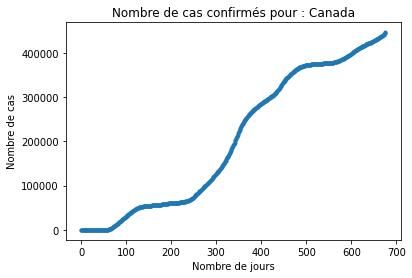

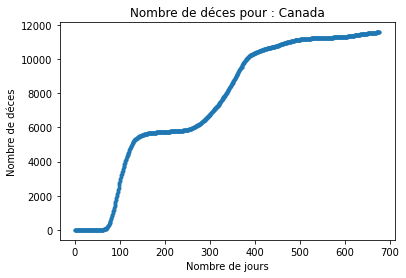

ValueError: x and y must have same first dimension, but have shapes (350,) and (349,)

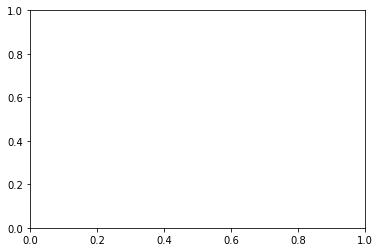

In [243]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(deaths_country_days, deaths_country_values, '.-')
plt.title("Nombre de déces pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de déces")
plt.show()

plt.plot(vaccination_index_days, vaccination_index_values, '.-')
plt.title("Nombre de vaccine pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de vaccine")
plt.show()

## Regression polynomiale (degré = 2)

In [ ]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split

Training and test sets


In [ ]:
confirmed_train, confirmed_test, confirmed_train_days, confirmed_test_days = train_test_split(confirmed_country_values, confirmed_country_days, test_size=0.30, shuffle=False)
deaths_train, deaths_test, deaths_train_days, deaths_test_days = train_test_split(deaths_country_values, deaths_country_days, test_size=0.30, shuffle=False)

In [ ]:
def regression(X, Y):
  reg = svm.SVR(kernel='poly', C=1000, degree=2)
  reg.fit(X, Y)
  return reg

reg_confirmed = regression(np.reshape(confirmed_train_days, newshape=(-1, 1)), confirmed_train)
reg_deaths = regression(np.reshape(deaths_train_days, newshape=(-1, 1)), deaths_train)

print("Regression cas : ", reg_confirmed.score(np.reshape(confirmed_test_days, newshape=(-1, 1)), confirmed_test))
print("Regression morts : ", reg_deaths.score(np.reshape(deaths_test_days, newshape=(-1, 1)), deaths_test))

Regression cas :  -57.4941867529062
Regression morts :  -2038.5589360293836


Visualisation des modèles

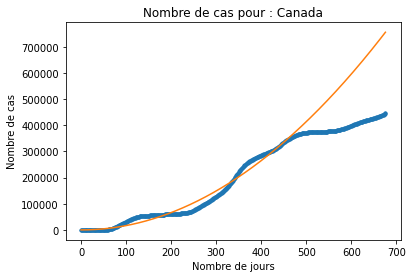

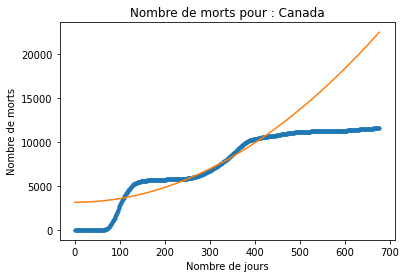

In [ ]:
def display_plot(reg, X, Y, ord_context):
  plt.plot(X, Y, '.-')
  plt.plot(X, reg.predict(X), "-")
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot(reg_confirmed, np.reshape(confirmed_country_days, newshape=(-1, 1)), confirmed_country_values, "cas")
display_plot(reg_deaths, np.reshape(deaths_country_days, newshape=(-1, 1)), deaths_country_values, "morts")

## Réseaux LSTM

In [ ]:
import tensorflow as tf
import keras as kr
from sklearn.preprocessing import MinMaxScaler

### Data preparation functions

In [ ]:
def create_sequences(data, time_steps=1):
  dataX, dataY = [], []
  for i in range(len(data)-time_steps):
    a = data[i:(i+time_steps)]
    dataX.append(a)
    dataY.append(data[i + time_steps][0])
  return np.array(dataX), np.array(dataY)

def create_lstm_sets(X, time_steps=1, scale=True, train_percent=0.75):
  scaler=None
  if scale:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
  else:
    scaled_X = np.array(X)
  train_size = int(len(scaled_X) * train_percent)
  test_size = len(scaled_X) - train_size
  train, test = scaled_X[0:train_size,:], scaled_X[train_size:len(scaled_X),:]
  return create_sequences(train, time_steps), create_sequences(test, time_steps), scaler

### Variable monodimensionelle & aucun historique en entrée

In [ ]:
time_steps = 1
n_features = 1

#### Fonction de création du modèle LSTM

In [ ]:
def lstm_network(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(100, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.LSTM(100))
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=25, batch_size=6);
  return model

#### Nombre de cas

In [ ]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (-1, 1))

In [ ]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (len(confirmed_lstm_set), 1))

confirmed_train, confirmed_test, confirmed_scaler = create_lstm_sets(confirmed_lstm_set, time_steps)

confirmed_trainX, confirmed_trainY = confirmed_train
confirmed_testX, confirmed_testY = confirmed_test

confirmed_lstm = lstm_network(confirmed_trainX, confirmed_trainY, time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
85/85 [==============================] 

#### Nombre de morts

In [ ]:
deaths_lstm_set = df_deaths_country.values[0]
deaths_lstm_set = np.reshape(deaths_lstm_set, (len(deaths_lstm_set), 1))

deaths_train, deaths_test, deaths_scaler = create_lstm_sets(deaths_lstm_set, time_steps)
deaths_trainX, deaths_trainY = deaths_train
deaths_testX, deaths_testY = deaths_test

deaths_lstm = lstm_network(deaths_trainX, deaths_trainY, time_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
85/85 [==============================

#### Vaccination par jour

In [ ]:
vaccination_lstm_set = df_vaccination_country["daily_vaccinations"].tolist()
vaccination_lstm_set = np.reshape(vaccination_lstm_set, (len(vaccination_lstm_set), 1))

vaccination_train, vaccination_test, vaccination_scaler = create_lstm_sets(vaccination_lstm_set, time_steps)

vaccination_trainX, vaccination_trainY = vaccination_train
vaccination_testX, vaccination_testY = vaccination_test

vaccination_lstm = lstm_network(vaccination_trainX, vaccination_trainY, time_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_4 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
44/44 [==============================

#### Affichage des résultats

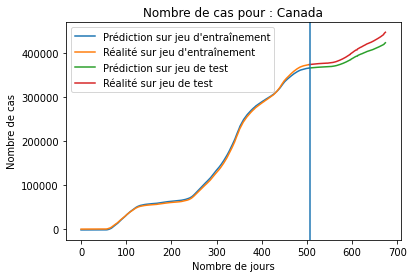

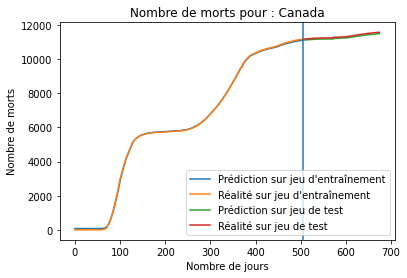

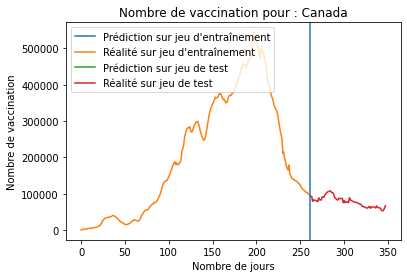

In [ ]:
def display_plot_lstm(model, scaler, trainX, trainY, testX, testY, country, ord_context):
  daysTrain = range(len(trainX))
  daysTest = np.array(range(len(testX))) + len(daysTrain)
  plt.plot(daysTrain, scaler.inverse_transform(model.predict(trainX)), '-', label="Prédiction sur jeu d'entraînement")
  plt.plot(daysTrain, scaler.inverse_transform(np.reshape(trainY, (-1, 1))), '-', label="Réalité sur jeu d'entraînement")

  plt.plot(daysTest, scaler.inverse_transform(model.predict(testX)), '-', label="Prédiction sur jeu de test")
  plt.plot(daysTest, scaler.inverse_transform(np.reshape(testY, (-1, 1))), '-', label="Réalité sur jeu de test")

  plt.axvline(len(trainX), 0, 1)
  plt.legend()
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot_lstm(confirmed_lstm, confirmed_scaler, confirmed_trainX, confirmed_trainY, confirmed_testX, confirmed_testY, country, "cas")
display_plot_lstm(deaths_lstm, deaths_scaler, deaths_trainX, deaths_trainY, deaths_testX, deaths_testY, country, "morts")
display_plot_lstm(vaccination_lstm, vaccination_scaler, vaccination_trainX, vaccination_trainY, vaccination_testX, vaccination_testY, country, "vaccination")

#### Prediction fonction

In [ ]:
def prediction_mono(starting_point, model, days=120):
    predictions = []
    test = starting_point
    for _ in range(days):
        pred = model.predict(test)
        predictions.append(pred[0][0])
        test = pred
    return predictions

In [ ]:
confirmed_preds = prediction_mono([[1.]], confirmed_lstm)
confirmed_scaler.inverse_transform([confirmed_preds])

array([[423381.97922766, 405690.63284814, 391833.18175822,
        380742.70060271, 371718.42563123, 364278.96527737,
        358081.4248848 , 352874.24721152, 348468.20860803,
        344718.15685868, 341510.63231319, 338755.72179258,
        336381.13536716, 334328.18655193, 332548.67096826,
        331002.71668017, 329657.04715952, 328483.76336515,
        327459.30551514, 326563.6810714 , 325779.79920909,
        325093.05153236, 324490.91275603, 323962.56800845,
        323498.69320646, 323091.17553249, 322733.00029442,
        322417.98471332, 322140.89771897, 321897.08059743,
        321682.47361228, 321493.53614092, 321327.1335344 ,
        321180.58370456, 321051.45080954, 320937.67170459,
        320837.38955945, 320749.01375607, 320671.12671435,
        320602.45727092, 320541.92726627, 320488.57833639,
        320441.50535971, 320399.99621853, 320363.41200352,
        320331.15373716, 320302.70896092, 320277.60514811,
        320255.4696016 , 320235.94959021, 320218.7389698

### Variables multi-dimensionnelles

#### (cas, stringency_index)

In [ ]:
time_steps = 40
n_features = 2

##### Get new data


In [ ]:
df_raw_stringency_index = pd.read_csv("covid-stringency-index.csv")
df_raw_stringency_index_country = df_raw_stringency_index[df_raw_stringency_index["Entity"] == country]
df_stringency_index_country = df_raw_stringency_index_country.drop(columns=["Entity", "Code"])
df_stringency_index_country.drop(index=df_stringency_index_country.index[0], axis=0, inplace=True)

stringency_index_values = list(df_stringency_index_country.stringency_index)[:len(confirmed_country_values)]
stringency_index_days = [i for i in range(df_stringency_index_country.Day.size)]

##### Adjust some data length (all equal)

In [ ]:
confirmed_country_values_ml_1 = confirmed_country_values[:len(stringency_index_values)]
confirmed_country_days_ml_1 = confirmed_country_days[:len(stringency_index_values)]

deaths_country_values_ml_1 = deaths_country_values[:len(stringency_index_values)]
deaths_country_days_ml_1 = deaths_country_days[:len(stringency_index_values)]

##### Print on a plot

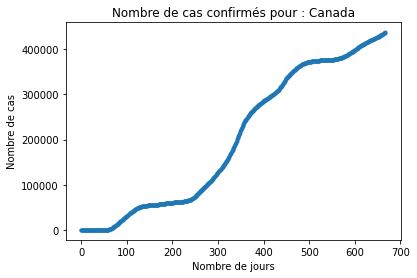

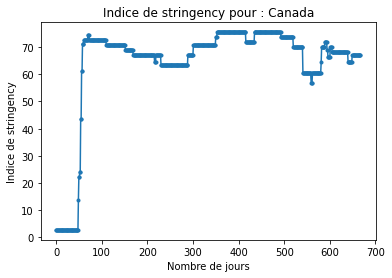

In [ ]:
plt.plot(confirmed_country_days_ml_1, confirmed_country_values_ml_1, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(stringency_index_days, stringency_index_values, '.-')
plt.title("Indice de stringency pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Indice de stringency")
plt.show()

##### Create data sets

In [ ]:
# Scaled values
confirmed_scaler = MinMaxScaler((-1, 1))
deaths_scaler = MinMaxScaler((-1, 1))
stringency_scaler = MinMaxScaler((-1, 1))

confirmed_scaler.fit(confirmed_country_values_ml_1.reshape((-1, 1)))
scaled_confirmed = confirmed_scaler.transform(confirmed_country_values_ml_1.reshape((-1, 1))).reshape((-1,))

deaths_scaler.fit(deaths_country_values_ml_1.reshape((-1, 1)))
scaled_deaths = deaths_scaler.transform(deaths_country_values_ml_1.reshape((-1, 1))).reshape((-1,))

stringency_scaler.fit(np.array(stringency_index_values).reshape((-1, 1)))
scaled_stringency = stringency_scaler.transform(np.array(stringency_index_values).reshape((-1, 1))).reshape((-1,))

In [ ]:
multi_data = list(zip(scaled_confirmed, scaled_stringency))

In [ ]:
multi_train, multi_test, _ = create_lstm_sets(multi_data, time_steps, scale=False, train_percent=0.70)
multi_trainX, multi_trainY = multi_train
multi_testX, multi_testY = multi_test

In [291]:
def lstm_network_multi(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(100, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.LSTM(300))
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=7, batch_size=4);
  return model

In [ ]:
multi_lstm = lstm_network_multi(multi_trainX, multi_trainY, time_steps, n_features)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 100)           41200     
                                                                 
 dropout_6 (Dropout)         (None, 40, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,701
Trainable params: 121,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
107/107 [=============================

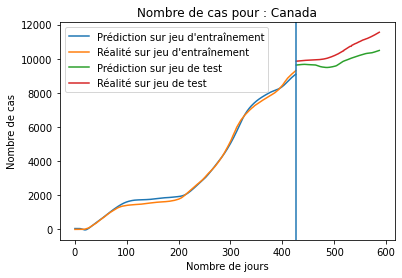

In [ ]:
display_plot_lstm(multi_lstm, deaths_scaler, multi_trainX, multi_trainY, multi_testX, multi_testY, country, "cas")

In [ ]:
n_days = 150
predictions = []
test = multi_trainX[-1-time_steps]
test = test.reshape(-1, time_steps, n_features)
start_day = len(multi_trainX)
for i in range(n_days):
    pred = multi_lstm.predict(test)
    predictions.append(pred[0][0])
    
    old = test[0][0]
    test = np.delete(test[0], 0, axis=0)

    indice = stringency_scaler.transform([[70]])
    if i > 75:
        indice = stringency_scaler.transform([[80]])

    test = np.append(test, [pred[0][0], indice[0][0]]).reshape(-1, time_steps, n_features)

    print(pred)

[[0.40993515]]
[[0.41235942]]
[[0.41504362]]
[[0.41788143]]
[[0.42080268]]
[[0.42376044]]
[[0.42672247]]
[[0.42966765]]
[[0.43258175]]
[[0.43545493]]
[[0.4382815]]
[[0.4410566]]
[[0.4437789]]
[[0.4464461]]
[[0.44905782]]
[[0.4516141]]
[[0.4541154]]
[[0.45656258]]
[[0.45895648]]
[[0.46129814]]
[[0.46358824]]
[[0.4658275]]
[[0.46801668]]
[[0.47015738]]
[[0.47224998]]
[[0.4742961]]
[[0.47629628]]
[[0.47825116]]
[[0.48016185]]
[[0.4820291]]
[[0.48385376]]
[[0.48564628]]
[[0.48739648]]
[[0.48910552]]
[[0.4907743]]
[[0.4924036]]
[[0.4939946]]
[[0.49554777]]
[[0.49706426]]
[[0.49854496]]
[[0.49999037]]
[[0.5013965]]
[[0.50277]]
[[0.5041108]]
[[0.50541973]]
[[0.50669736]]
[[0.5079441]]
[[0.5091604]]
[[0.51034737]]
[[0.5115052]]
[[0.5126347]]
[[0.5137365]]
[[0.51481116]]
[[0.51585925]]
[[0.5168815]]
[[0.5178784]]
[[0.51885045]]
[[0.51979816]]
[[0.5207226]]
[[0.52162373]]
[[0.5225022]]
[[0.5233587]]
[[0.5241938]]
[[0.52500767]]
[[0.525801]]
[[0.5265743]]
[[0.5273283]]
[[0.52806294]]
[[0.5287788]

In [ ]:
predicted_plot = np.concatenate((confirmed_scaler.transform(confirmed_country_values_ml_1[:start_day].reshape((-1, 1))).reshape((-1,)), predictions))
predicted_plot = confirmed_scaler.inverse_transform(predicted_plot.reshape((-1, 1)))

days = np.concatenate((list(range(start_day)), np.array([day for day in range(start_day, start_day+n_days)])))

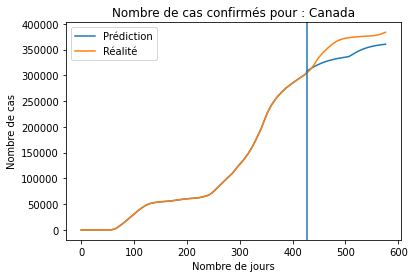

In [ ]:
plt.plot(days, predicted_plot, '-', label="Prédiction")
plt.plot(days, confirmed_country_values_ml_1[:start_day+n_days], '-', label="Réalité")
plt.legend()
plt.axvline(start_day)
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

#### (cas, stringency_index, vaccination)

In [330]:
time_steps = 40
n_features = 3

##### Adjust some data length (all equal)

In [331]:
confirmed_country_values_ml_2 = confirmed_country_values[327:667]
confirmed_country_days_ml_2 = confirmed_country_days[327:667]

vaccination_index_values_ml_2 = np.array(vaccination_index_values[:340])
vaccination_index_days_ml_2 = np.array(vaccination_index_days[:340])

stringency_index_values_ml_2 = stringency_index_values[327:327+340]
stringency_index_days_ml_2 = stringency_index_days[327:327+340]

##### Create data sets

In [332]:
# Scaled values
confirmed_scaler = MinMaxScaler((-1, 1))
vaccination_scaler = MinMaxScaler((-1, 1))
stringency_scaler = MinMaxScaler((-1, 1))

confirmed_scaler.fit(confirmed_country_values_ml_2.reshape((-1, 1)))
scaled_confirmed = confirmed_scaler.transform(confirmed_country_values_ml_2.reshape((-1, 1))).reshape((-1,))

vaccination_scaler.fit(vaccination_index_values_ml_2.reshape((-1, 1)))
scaled_vaccinations = vaccination_scaler.transform(vaccination_index_values_ml_2.reshape((-1, 1))).reshape((-1,))

stringency_scaler.fit(np.array(stringency_index_values_ml_2).reshape((-1, 1)))
scaled_stringency = stringency_scaler.transform(np.array(stringency_index_values_ml_2).reshape((-1, 1))).reshape((-1,))

In [333]:
multi_data = list(zip(scaled_confirmed, scaled_stringency, scaled_vaccinations))

In [334]:
multi_train, multi_test, _ = create_lstm_sets(multi_data, time_steps, scale=False, train_percent=0.70)
multi_trainX, multi_trainY = multi_train
multi_testX, multi_testY = multi_test

In [335]:
multi_lstm = lstm_network_multi(multi_trainX, multi_trainY, time_steps, n_features)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 40, 100)           41600     
                                                                 
 dropout_28 (Dropout)        (None, 40, 100)           0         
                                                                 
 lstm_29 (LSTM)              (None, 300)               481200    
                                                                 
 dropout_29 (Dropout)        (None, 300)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                 301       
                                                                 
Total params: 523,101
Trainable params: 523,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
50/50 [==============================

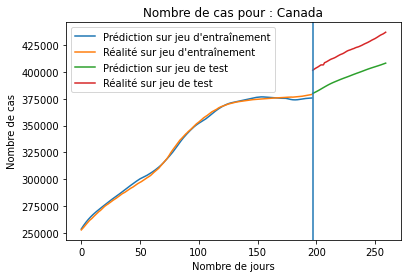

In [336]:
display_plot_lstm(multi_lstm, confirmed_scaler, multi_trainX, multi_trainY, multi_testX, multi_testY, country, "cas")

In [352]:
n_days = 100
predictions = []
test = multi_trainX[-1-time_steps]
test = test.reshape(-1, time_steps, n_features)
start_day = 327+len(multi_trainX)
print(start_day)
for i in range(n_days):
    pred = multi_lstm.predict(test)
    predictions.append(pred[0][0])
    
    old = test[0][0]
    test = np.delete(test[0], 0, axis=0)
    
    indice = stringency_scaler.transform([[85]])
    if i > 500:
        indice = stringency_scaler.transform([[95]])

    test = np.append(test, [pred[0][0], indice[0][0], 1.]).reshape((-1, time_steps, n_features))

    print(pred)

524
[[0.55268973]]
[[0.55415004]]
[[0.5576287]]
[[0.5625122]]
[[0.5682657]]
[[0.5744642]]
[[0.58078825]]
[[0.58700997]]
[[0.5929798]]
[[0.5986087]]
[[0.603852]]
[[0.6086921]]
[[0.6131441]]
[[0.6172277]]
[[0.62097025]]
[[0.6244001]]
[[0.6275486]]
[[0.6304445]]
[[0.6331155]]
[[0.6355856]]
[[0.6378772]]
[[0.64001]]
[[0.6419998]]
[[0.643861]]
[[0.64560616]]
[[0.6472464]]
[[0.64879084]]
[[0.6502486]]
[[0.6516261]]
[[0.65292716]]
[[0.6541587]]
[[0.6553252]]
[[0.65642977]]
[[0.6574773]]
[[0.6584724]]
[[0.6594193]]
[[0.6603217]]
[[0.66117936]]
[[0.6619872]]
[[0.6627578]]
[[0.6634997]]
[[0.6642588]]
[[0.664977]]
[[0.6656565]]
[[0.6663002]]
[[0.6669096]]
[[0.6674876]]
[[0.6680348]]
[[0.66855353]]
[[0.66904694]]
[[0.6695143]]
[[0.66995895]]
[[0.6703811]]
[[0.6707821]]
[[0.6711636]]
[[0.6715258]]
[[0.6718702]]
[[0.67219794]]
[[0.6725093]]
[[0.6728058]]
[[0.67308724]]
[[0.6733553]]
[[0.67361003]]
[[0.6738524]]
[[0.6740829]]
[[0.674302]]
[[0.6745104]]
[[0.67470884]]
[[0.6748974]]
[[0.6750764]]
[[0.6

In [353]:
predicted_plot = np.concatenate((confirmed_scaler.transform(confirmed_country_values[327:start_day].reshape((-1, 1))).reshape((-1,)), predictions))
predicted_plot = confirmed_scaler.inverse_transform(predicted_plot.reshape((-1, 1))).reshape((-1,))

days = list(range(327, start_day+n_days))

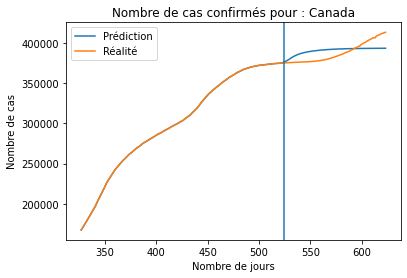

In [354]:
plt.plot(days, predicted_plot, '-', label="Prédiction")
plt.plot(days, confirmed_country_values[327:start_day+n_days], '-', label="Réalité")
plt.legend()
plt.axvline(start_day)
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()